<a href="https://colab.research.google.com/github/7u7unn/Underwater-Enhancement-CycleGAN/blob/main/cycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import drive

print("Library diimpor.")

Library diimpor.


In [ ]:
# Mount Google Drive untuk mengakses dataset Anda
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Sesuaikan path ini dengan path folder dataset Anda di Google Drive
PATH = '/content/drive/MyDrive/Kel 4: Project Comvis/Dataset'  # Ganti dengan path folder utama dataset Anda

# Path ke folder dataset
path_high_turbidity = os.path.join(PATH, "HIGH2")
path_low_turbidity = os.path.join(PATH, "LOW2")

# Ambil daftar file
list_high_turbidity = sorted(glob.glob(os.path.join(path_high_turbidity, '*.jpg')) + glob.glob(os.path.join(path_high_turbidity, '*.png')))
list_low_turbidity = sorted(glob.glob(os.path.join(path_low_turbidity, '*.jpg')) + glob.glob(os.path.join(path_low_turbidity, '*.png')))

print(f"Jumlah gambar High Turbidity: {len(list_high_turbidity)}")
print(f"Jumlah gambar Low Turbidity: {len(list_low_turbidity)}")

Jumlah gambar High Turbidity: 156
Jumlah gambar Low Turbidity: 123


In [ ]:
# Konfigurasi ukuran gambar
IMG_WIDTH = 256
IMG_HEIGHT = 256
AUTOTUNE = tf.data.AUTOTUNE

def load_image(image_file):
    image = tf.io.read_file(image_file)
    # Gunakan decode_image untuk format umum (jpg, png, gif)
    # expand_animations=False untuk menghindari masalah dengan GIF
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    # Decode_image menghasilkan tensor tanpa bentuk statis, jadi kita tetapkan bentuknya
    image.set_shape([None, None, 3]) # Atur bentuk agar (tinggi, lebar, channel) diketahui
    image = tf.cast(image, tf.float32)
    return image

def resize(image, height=IMG_HEIGHT, width=IMG_WIDTH):
    image = tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

def normalize(image):
    image = (image / 127.5) - 1  # Normalisasi ke [-1, 1]
    return image

def preprocess_image(image_file):
    image = load_image(image_file)
    image = resize(image)
    image = normalize(image)
    # Pastikan bentuk akhirnya benar
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    return image

In [ ]:
# Membuat dataset dari path
dataset_high = tf.data.Dataset.from_tensor_slices(list_high_turbidity)
dataset_low = tf.data.Dataset.from_tensor_slices(list_low_turbidity)

# Terapkan fungsi preprocessing
dataset_high = dataset_high.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(1)
dataset_low = dataset_low.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(1)

print("Dataset dibuat.")

Dataset dibuat.


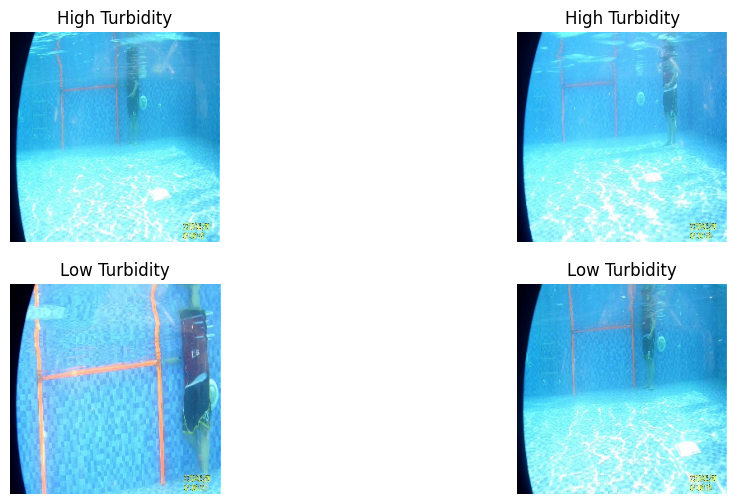

In [ ]:
def visualize_dataset_samples(dataset_a, dataset_b, num_samples=2):
    iterator_a = iter(dataset_a)
    iterator_b = iter(dataset_b)
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        example_a = next(iterator_a)
        example_b = next(iterator_b)

        plt.subplot(2, num_samples, i + 1)
        plt.imshow(example_a[0] * 0.5 + 0.5) # Denormalize untuk visualisasi
        plt.title("High Turbidity")
        plt.axis('off')

        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(example_b[0] * 0.5 + 0.5) # Denormalize untuk visualisasi
        plt.title("Low Turbidity")
        plt.axis('off')
    plt.show()

visualize_dataset_samples(dataset_high, dataset_low)

In [ ]:
class InstanceNormalization(layers.Layer):
    """Instance Normalization implementation"""
    def __init__(self, epsilon=1e-6, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=[input_shape[-1],],
            initializer=tf.random_normal_initializer(0., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=[input_shape[-1],],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(InstanceNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def ResidualBlock(filters):
    """ResNet block with Instance Normalization"""
    def apply(x):
        initializer = tf.random_normal_initializer(0., 0.02)

        # First conv block
        fx = layers.Conv2D(filters, 3, strides=1, padding='same',
                          kernel_initializer=initializer, use_bias=False)(x)
        fx = InstanceNormalization()(fx)
        fx = layers.ReLU()(fx)

        # Second conv block
        fx = layers.Conv2D(filters, 3, strides=1, padding='same',
                          kernel_initializer=initializer, use_bias=False)(fx)
        fx = InstanceNormalization()(fx)

        # Residual connection
        return layers.Add()([x, fx])

    return apply

def Generator():
    """ResNet-based Generator (CycleGAN style)"""
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    initializer = tf.random_normal_initializer(0., 0.02)

    # Initial convolution - c7s1-64
    x = layers.Conv2D(64, 7, strides=1, padding='same',
                     kernel_initializer=initializer, use_bias=False)(inputs)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling - d128, d256
    x = downsample(128, 3)(x)  # (bs, 128, 128, 128)
    x = downsample(256, 3)(x)  # (bs, 64, 64, 256)

    # ResNet blocks - R256 (9 blocks for 256x256 images)
    num_resnet_blocks = 9
    for i in range(num_resnet_blocks):
        x = ResidualBlock(256)(x)

    # Upsampling - u128, u64
    x = upsample(128, 3)(x)  # (bs, 128, 128, 128)
    x = upsample(64, 3)(x)   # (bs, 256, 256, 64)

    # Output layer - c7s1-3
    x = layers.Conv2D(3, 7, strides=1, padding='same',
                     kernel_initializer=initializer,
                     activation='tanh')(x)  # (bs, 256, 256, 3)

    return keras.Model(inputs=inputs, outputs=x, name='generator')

def Discriminator():
    """PatchGAN Discriminator"""
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = InstanceNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

# Initialize models
generator_g = Generator()
generator_f = Generator()
discriminator_x = Discriminator()
discriminator_y = Discriminator()

print("Generator dan Discriminator berhasil dibuat.")

Generator dan Discriminator berhasil dibuat.


In [ ]:
# Use LSGAN loss (Mean Squared Error)
loss_obj = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, generated):
    """Discriminator loss with LABEL SMOOTHING"""
    # Label smoothing: 0.9 instead of 1.0, 0.1 instead of 0.0
    real_loss = loss_obj(tf.ones_like(real) * 0.9, real)
    generated_loss = loss_obj(tf.zeros_like(generated) + 0.1, generated)

    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    """Generator loss - wants discriminator to output 1"""
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    """Cycle consistency loss"""
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    """Identity loss - generator should preserve images from target domain"""
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Discriminators learn slower to prevent dominance
discriminator_x_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/cyclegan_checkpoints"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Jika checkpoint ditemukan, restore
if ckpt_manager.latest_checkpoint:
    try:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print ('Checkpoint dipulihkan dari latest_checkpoint')
    except (tf.errors.OpError, ValueError) as e:
        print(f"Error restoring checkpoint: {e}. Training will start from scratch.")
else:
    print("No checkpoint found. Training will start from scratch.")


Checkpoint dipulihkan dari latest_checkpoint


In [ ]:
@tf.function
def train_step(real_x, real_y, LAMBDA, update_discriminator=True):
    """
    Training step with improvements:
    - Noise injection to discriminator inputs
    - Conditional discriminator updates
    - Proper identity loss using same-domain images
    """
    with tf.GradientTape(persistent=True) as tape:
        # ===== FORWARD PASS =====

        # Generate fake images
        fake_y = generator_g(real_x, training=True)  # X -> Y (High -> Low turbidity)
        cycled_x = generator_f(fake_y, training=True)  # Y -> X (back to high)

        fake_x = generator_f(real_y, training=True)  # Y -> X (Low -> High turbidity)
        cycled_y = generator_g(fake_x, training=True)  # X -> Y (back to low)

        # Identity mapping (generator should preserve images from target domain)
        same_y = generator_g(real_y, training=True)  # G should not change real_y
        same_x = generator_f(real_x, training=True)  # F should not change real_x

        # ===== NOISE INJECTION =====
        # Add small noise to discriminator inputs for stability
        noise_factor = 0.05
        real_x_noisy = real_x + tf.random.normal(tf.shape(real_x), stddev=noise_factor)
        real_y_noisy = real_y + tf.random.normal(tf.shape(real_y), stddev=noise_factor)
        fake_x_noisy = fake_x + tf.random.normal(tf.shape(fake_x), stddev=noise_factor)
        fake_y_noisy = fake_y + tf.random.normal(tf.shape(fake_y), stddev=noise_factor)

        # ===== DISCRIMINATOR OUTPUTS =====
        disc_real_x = discriminator_x(real_x_noisy, training=True)
        disc_real_y = discriminator_y(real_y_noisy, training=True)

        disc_fake_x = discriminator_x(fake_x_noisy, training=True)
        disc_fake_y = discriminator_y(fake_y_noisy, training=True)

        # ===== CALCULATE LOSSES =====

        # Generator adversarial loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # Cycle consistency loss
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x, LAMBDA) + calc_cycle_loss(real_y, cycled_y, LAMBDA)

        # Identity loss
        total_identity_loss = identity_loss(real_y, same_y, LAMBDA) + identity_loss(real_x, same_x, LAMBDA)

        # Total generator loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + total_identity_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss + total_identity_loss

        # Discriminator loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # ===== ALWAYS UPDATE GENERATORS =====
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    # ===== CONDITIONALLY UPDATE DISCRIMINATORS =====
    # Update discriminators less frequently to prevent dominance
    if update_discriminator:
        discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

        discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
        discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [ ]:
import time

def fit(train_ds_a, train_ds_b, epochs, LAMBDA=15):
    """
    Training loop with:
    - Increased LAMBDA for better structure preservation
    - Conditional discriminator updates (every 2 steps)
    - Better progress tracking
    """
    for epoch in range(epochs):
        start = time.time()
        print(f"\nStarting Epoch: {epoch+1}/{epochs}")

        n = 0
        for image_x, image_y in tf.data.Dataset.zip((train_ds_a, train_ds_b)):
            # Update discriminators every 2 steps (generators update every step)
            update_disc = (n % 2 == 0)

            total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(
                image_x, image_y, LAMBDA, update_discriminator=update_disc
            )

            n += 1
            if n % 10 == 0:
                print('.', end='')

            # Print detailed stats every 50 steps
            if n % 50 == 0:
                print(f"\nStep {n}: Gen G: {total_gen_g_loss:.4f}, Gen F: {total_gen_f_loss:.4f}, "
                      f"Disc X: {disc_x_loss:.4f}, Disc Y: {disc_y_loss:.4f}")

        print()

        # Visualize results
        clear_output(wait=True)
        for inp in train_ds_a.take(1):
            generate_images(generator_g, inp)

        print(f"\n{'='*60}")
        print(f"Epoch: {epoch+1}/{epochs} COMPLETED")
        print(f"Gen G Loss: {total_gen_g_loss:.4f}, Gen F Loss: {total_gen_f_loss:.4f}")
        print(f"Disc X Loss: {disc_x_loss:.4f}, Disc Y Loss: {disc_y_loss:.4f}")
        print(f"Time taken: {time.time()-start:.2f} sec")
        print(f"{'='*60}\n")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print(f'\u2713 Checkpoint saved for epoch {epoch+1} at {ckpt_save_path}')

    print('\n\ud83c\udf89 Training completed successfully!')

def generate_images(model, test_input):
    """Generate and display images"""
    prediction = model(test_input, training=False)

    plt.figure(figsize=(12, 4))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Generated Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Denormalize [-1, 1] to [0, 1] for visualization
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

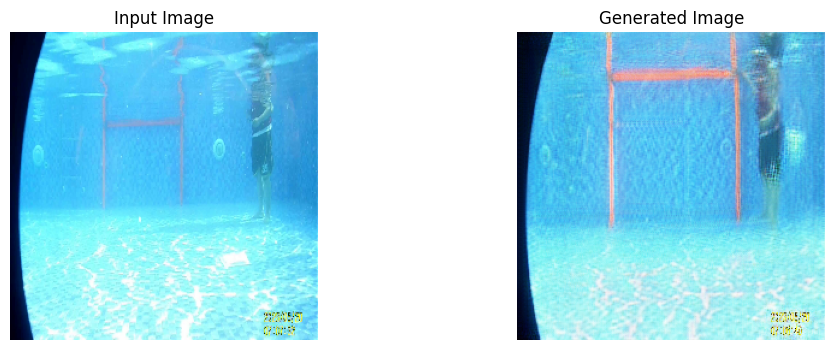


Epoch: 35/35 COMPLETED
Gen G Loss: 2.1513, Gen F Loss: 2.1703
Disc X Loss: 0.0539, Disc Y Loss: 0.1191
Time taken: 90.51 sec



ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 118-119: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/zmq/eventloop/zmqstream.py", line 551, in _run_callback
    f = callback(*args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 120, in _handle_event
    event_f()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to

In [ ]:
EPOCHS = 35
LAMBDA = 15  # Increased from 10 for better structure preservation

fit(dataset_high, dataset_low, EPOCHS, LAMBDA=LAMBDA)





Generating test results...


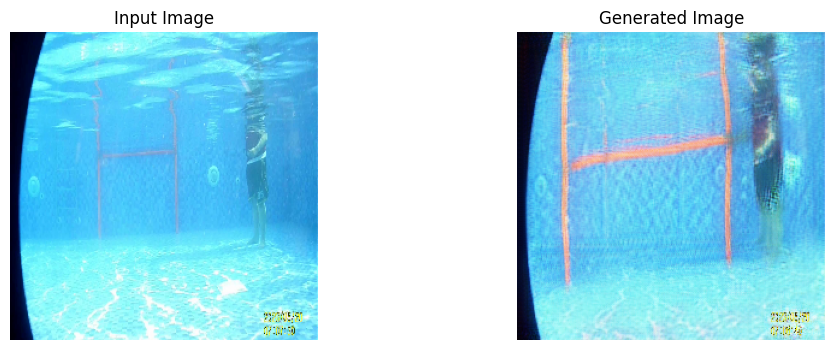

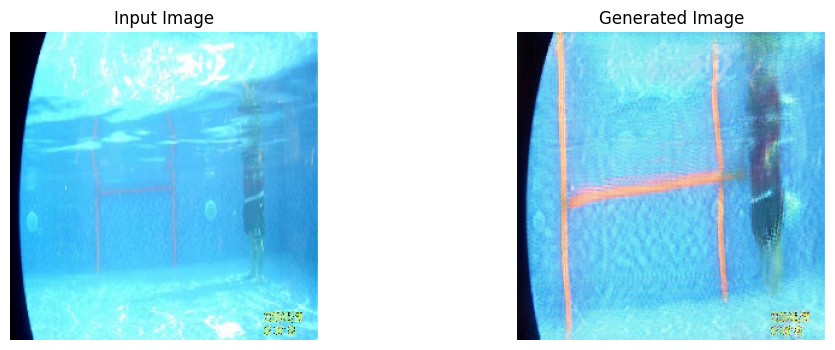

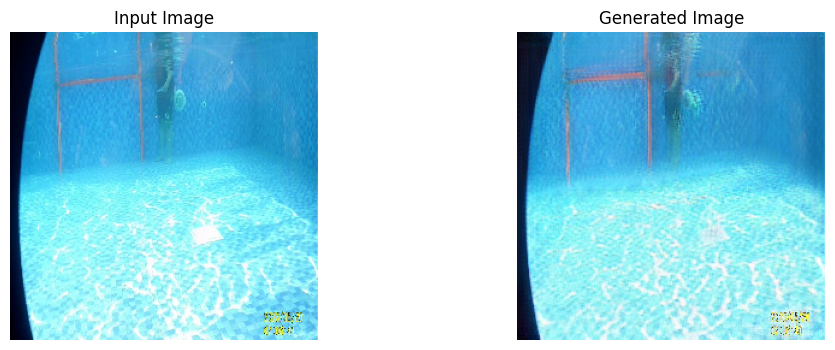

In [ ]:
print("\nGenerating test results...")
for example in dataset_high.take(3):
    generate_images(generator_g, example)